The goal of this notebook is to fine-tune the all-Mini or bge-small embedding models by adding a classifier to determine whether a text segment is relevant or not. For example, article references are not useful for our knowledge graph generation task.

Currently, this model is only used in the context of the TF-IDF metric to extract keywords, helping to filter out irrelevant terms, such as those from references.

In [ ]:
from transformers import AutoModel
import torch.nn as nn
import torch
from torch.utils.data import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import json

In [2]:
def get_device():
    if torch.cuda.is_available():
        print(f"Using GPU: {torch.cuda.current_device()}")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using MPS")
        return torch.device("mps")
    else:
        print("Using CPU")
        return torch.device("cpu")

device = get_device()

Using MPS


In [6]:
with open('data/training_data_usable_text.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

train_df, val_df = train_test_split(df, test_size=0.1, random_state=33)

train_df.info()
print()
val_df.info()

print("Ensemble d'entraînement:")
print(train_df.head())

print("\nEnsemble de validation:")
print(val_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 604 entries, 326 to 20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    604 non-null    object
 1   usable  604 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.2+ KB

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 469 to 121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    68 non-null     object
 1   usable  68 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
Ensemble d'entraînement:
                                                  text  usable
326  The structure of scientific revolutions, Chica...       0
321  The Constitution of Liberty . London: Routledg...       0
204  © Hermann. All rights reserved for all countri...       1
176  Kahneman Daniel ( 2012), System 1/System 2: th...       0
583  HIRSCHMAN A. O. [1977], Passions and interests...       0

Ensemb

In [ ]:
class UsableTextClassifier(nn.Module):
    def __init__(self, pretrained_model_name):
        super(UsableTextClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.dense1 = nn.Linear(self.encoder.config.hidden_size, 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.dense4 = nn.Linear(64, 32)
        self.dense5 = nn.Linear(32, 32)
        
        self.dropout = nn.Dropout(0.3)

        self.classifier = nn.Linear(32, 1)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  

        x = self.dense1(pooled_output)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.relu(x)

        x = self.dense4(x)
        x = self.relu(x)
        x = self.dense5(x)
        x = self.relu(x)

        logits = self.classifier(x)
        logits = logits.squeeze(-1)  
        
        return logits

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        inputs = self.tokenizer(
            row['text'],
            padding='max_length',
            truncation=True,
            max_length=128,  
            return_tensors='pt' 
        )

        inputs = {key: val.squeeze(0) for key, val in inputs.items()}

        label = torch.tensor(float(row['usable']))

        return inputs, label


In [21]:
%%capture
model_name_1 = 'sentence-transformers/all-MiniLM-L6-v2'
model_name_2 = 'BAAI/bge-small-en-v1.5'
model_name_3 = 'BAAI/bge-large-en-v1.5'
model = UsableTextClassifier(model_name_2)
tokenizer = AutoTokenizer.from_pretrained(model_name_2)
train_dataset = TextDataset(train_df, tokenizer)
val_dataset = TextDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.BCEWithLogitsLoss()

In [11]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.round(torch.sigmoid(outputs)).squeeze()
        correct_predictions += torch.sum(preds == labels).item()

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / (len(data_loader.dataset))
    return avg_loss, avg_accuracy


def validate_epoch(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)
            loss = loss_fn(outputs, labels.float())
            total_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(actuals, predictions)
    return avg_loss, accuracy

In [22]:
model.to(device)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []

# Training loop
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_accuracy = validate_epoch(model, val_loader, loss_fn, device)

    loss_history.append(train_loss)
    acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

100%|██████████| 10/10 [02:47<00:00, 16.74s/it]


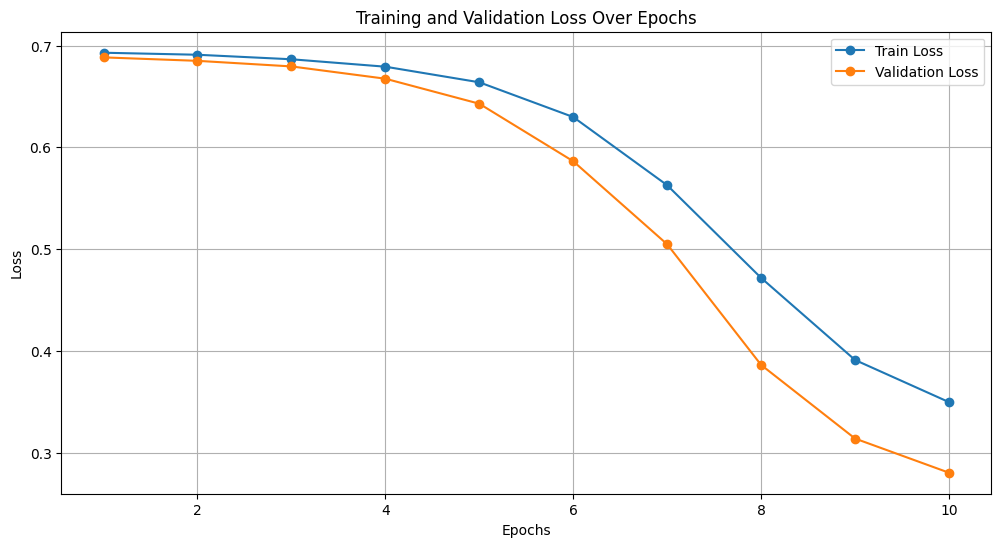

In [23]:
plt.figure(figsize=(12, 6))

plt.plot(range(1, epochs + 1), loss_history, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_loss_history, label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

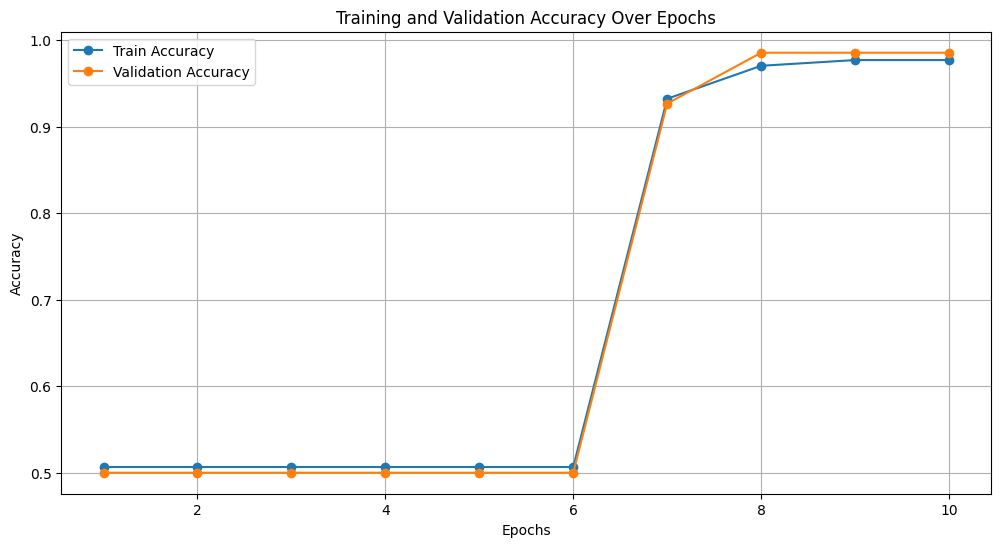

0.9852941176470589


In [24]:
plt.figure(figsize=(12, 6))

plt.plot(range(1, epochs + 1), acc_history, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_acc_history, label='Validation Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

print(np.max(val_acc_history))

In [25]:
print(acc_history)
print(val_acc_history)

[0.5066225165562914, 0.5066225165562914, 0.5066225165562914, 0.5066225165562914, 0.5066225165562914, 0.5066225165562914, 0.9321192052980133, 0.9701986754966887, 0.9768211920529801, 0.9768211920529801]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9264705882352942, 0.9852941176470589, 0.9852941176470589, 0.9852941176470589]


Save the model

In [ ]:
output_dir = "../../models"
os.makedirs(output_dir, exist_ok=True)  
model_path = os.path.join(output_dir, "finetuning_usable_text.pth")

torch.save(model, model_path)
print(f"Model saved at : {model_path}")

Modèle sauvegardé à : ../models/finetuning_usable_text.pth
